In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

## Own code 
import import_ipynb
import metadata_options
import models_nn

importing Jupyter notebook from metadata_options.ipynb
importing Jupyter notebook from models_nn.ipynb


In [3]:
# Data with Throughput & WorkTime
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
df = df.dropna()

In [4]:
######################################
## Model Options ##
######################################
# options: lstm, cnn, lstm-attn

model_name = 'lstm-attn'
models_nn.MODEL_NAME = model_name

In [5]:
df.head()

,Input.sentence_id,HITId,Input.convo_id,Input.train_test_val,Input.msg_id,Input.timestamp,Input.full_text,Input.speaker,Input.reply_to,Input.speaker_intention,...,prt,punct,purpcl,quantmod,rcmod,rel,root,tmod,xcomp,xsubj
5,11,3MG8450X2OASXZ0WO9O5AH70GU3UPA,Game1-italy-germany,Train,Game1-italy-germany-3,87,It seems like there are a lot of ways that cou...,germany-Game1,Game1-italy-germany-2,Truth,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,12,38G0E1M85M552JXSALX4G9WI2I6UVX,Game1-italy-germany,Train,Game1-italy-germany-7,117,"Sorry Italy I've been away doing, um, German t...",germany-Game1,Game1-italy-germany-6,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,14,3HYV4299H0WQ2B4TCS7PKDQ75WHE81,Game1-italy-germany,Train,Game1-italy-germany-8,119,"I don't think I'm ready to go for that idea, h...",germany-Game1,Game1-italy-germany-7,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,15,3XU9MCX6VOC4P079IHIO9TCNYLGR2P,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am pretty conflicted about whether to guess ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,16,3FVBZG9CLJEK4WQS7P2GC1H2EEQH0Q,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am going to take it literally and say even ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0


In [6]:
###################################
# pipeline-onehot Function blocks #
###################################

def sss_train_test_split(dataframe, class_name, n_splits, test_size, random_state):
    y = dataframe[class_name].copy()
    X = dataframe.drop([class_name], axis=1)
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    splits_generator = sss.split(X, y)

    for train_idx, test_idx in splits_generator:
        indices_train = train_idx
        indices_test = test_idx

    train = df.take(indices_train)
    test = df.take(indices_test)
    
    return indices_train, indices_test, train, test

def generate_class_weights(train_data, class_name, annotation_name):
    # Check if first class label is numeric or alphabetic
    if class_name == annotation_name:
        ## Convert to int type
        tmp_y_train = train_data[annotation_name].copy()
        tmp_y_train[annotation_name] = train_data[annotation_name].apply(lambda x : 1 if x == "Straightforward" else 0)
        y_train = tmp_y_train[annotation_name].to_numpy()
    else:
        y_train = train_data[annotation_name].to_numpy()
    
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    return y_train, class_weight_dict

def label_preprocessing(y_data, label_encoder):
    out = label_encoder.fit_transform(y_data).reshape(-1,1)
    return out

def individual_model(annot_name, x_train_data, y_train_data, x_val_data, y_val_data, class_weight_dict, indiv_batch_size, indiv_epochs):
    model = models_nn.create_nn_model()
    model.compile(loss = 'binary_crossentropy',
                  optimizer = RMSprop(),
                  metrics = ['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
    history = model.fit(x_train_data,y_train_data,
                        batch_size=indiv_batch_size,
                        epochs=indiv_epochs,
                        validation_data=(x_val_data, y_val_data), 
                        callbacks=[models_nn.early_stop],
                        class_weight=class_weight_dict,
                        verbose=0)
    
    pred = model.predict(x_train_data)
    pred_test = model.predict(x_val_data)

    pred_test_round = pred_test.round()
    
    validation_metrics_dict = history.history
    val_f1_list = history.history['val_f1_m']
    best_val_f1 = max(val_f1_list)
    best_val_prec = history.history['val_precision_m'][val_f1_list.index(best_val_f1)]
    best_val_recall = history.history['val_recall_m'][val_f1_list.index(best_val_f1)]
    macro_scores = precision_recall_fscore_support(y_val_data, pred_test_round, average='macro')
    print("#############################################################")
    print("Metrics for {} individual model:".format(annot_name))
    print("Best validation metrics: F1 = {}, Precision = {}, Recall = {}".format(best_val_f1,
                                                                                 best_val_prec,
                                                                                 best_val_recall))
    print("Macro validation metrics: F1 = {}, Precision = {}, Recall = {}".format(macro_scores[2],
                                                                                  macro_scores[0],
                                                                                  macro_scores[1]))
    return pred, pred_test

# (HARD-CODED)
def generate_encodings(gamemove_pred, reasoning_pred, shareinfo_pred, rapport_pred):
    pred_df_arr_full = []
    pred_df_arr = []
    for i in range(0, len(gamemove_pred)):
        pred_obj_1 = {}
        pred_obj_1['gamemove'] = gamemove_pred[i][0]
        pred_obj_1['reasoning'] = reasoning_pred[i][0]
        pred_obj_1['shareinfo'] = shareinfo_pred[i][0]
        pred_df_arr.append(pred_obj_1)

        pred_obj_2 = pred_obj_1.copy()
        pred_obj_2['rapport'] = rapport_pred[i][0]
        pred_df_arr_full.append(pred_obj_2)

    pred_df_full = pd.DataFrame(pred_df_arr_full)
    pred_df = pd.DataFrame(pred_df_arr)
    return pred_df_full, pred_df

def joint_model(weights_name, pred_df_full, y_train_1, pred_df_full_test, y_test_1,
                pred_df, y_train_2, pred_df_test, y_test_2,
                class_weight_dict_1, class_weight_dict_2, joint_batch_size, joint_epochs):
    def helper(predict_name, pred_df, y_train, pred_df_test, y_test, class_weight_dict_1, joint_batch_size, joint_epochs):
        joint_full_model_1 = models_nn.create_joint_model(pred_df_full)
        history_1 = joint_full_model_1.fit(x=pred_df_full, 
                                           y=y_train_1, 
                                           epochs=joint_epochs, 
                                           batch_size=joint_batch_size, 
                                           validation_data=(pred_df_full_test,y_test_1), 
                                           callbacks=[models_nn.callback], 
                                           class_weight=class_weight_dict_1,
                                           verbose=0)
        joint_predict_1 = joint_full_model_1.predict(pred_df_full_test)
        joint_predict_round_1 = []
        for a in joint_predict_1:
            joint_predict_round_1.append(np.argmax(a))
        out1 = precision_recall_fscore_support(y_test_1, np.array(joint_predict_round_1), average='macro')

        val_f1_list = history_1.history['val_f1_m']
        best_val_f1 = max(val_f1_list)
        best_val_prec = history_1.history['val_precision_m'][val_f1_list.index(best_val_f1)]
        best_val_recall = history_1.history['val_recall_m'][val_f1_list.index(best_val_f1)]
        macro_scores = out1
        if weights_name == None:
            print("Metrics for {} joint model w/o weights:".format(predict_name))
        else:
            print("Metrics for {} joint model weighted by {}".format(predict_name, weights_name))
        print("Best validation metrics: F1 = {}, Precision = {}, Recall = {}".format(best_val_f1,
                                                                                     best_val_prec,
                                                                                     best_val_recall))
        print("Macro validation metrics: F1 = {}, Precision = {}, Recall = {}".format(macro_scores[2],
                                                                                      macro_scores[0],
                                                                                      macro_scores[1]))
        return [best_val_f1, best_val_prec, best_val_recall], macro_scores
    
    print("#############################################################")
    decep_1, decep_2 = helper("Deception", pred_df_full, y_train_1, pred_df_full_test, y_test_1, class_weight_dict_1, joint_batch_size, joint_epochs)
    rapport_1, rapport_2 = helper("Rapport", pred_df, y_train_2, pred_df_test, y_test_2, class_weight_dict_2, joint_batch_size, joint_epochs)

    
    return decep_1, decep_2, rapport_1, rapport_2

In [7]:
##################################################
# Main function for dataset sampling experiments #
##################################################

# Currently only supports annotations with 2 classes, i.e. binary

def dataset_sampling(dataframe, class_name, sampling_size_list, metadata_options_list, model_name):
    
    # Misc variables
    results = {}
    
    # Model settings (for individual annotation models)
    models_nn.MODEL_NAME = model_name
    
    # Full dataframe proportions
    full_size = dataframe.shape[0]
    full_counts = dataframe[class_name].value_counts()
    print("Full dataset proportions w.r.t. {}".format(class_name))
    print(full_counts)
    full_counts_dict = full_counts.to_dict()
    full_counts_list = list(full_counts_dict.values())
    
    ## class_proportions is a list of class proportions, first item corresponding to first class, etc
    class_proportions = []
    for each_class_counts in full_counts_list:
        class_proportions.append(each_class_counts / full_size)

    # Looping through sample_size_list
    for each_sample_size in sampling_size_list:
        
        print("#################################")
        print("Sample size: {}".format(each_sample_size))
        print("#################################")
        
        ## Counting number of datapoints per class proportionate to main dataset
        class_sizes = [round(each_sample_size * class_proportions[0])]
        class_sizes.append(each_sample_size - class_sizes[0])

        ## Creating sub dataframe
        s0 = dataframe.loc[dataframe[class_name] == list(full_counts_dict.keys())[0]].sample(class_sizes[0]).index
        s1 = dataframe.loc[dataframe[class_name] == list(full_counts_dict.keys())[1]].sample(class_sizes[1]).index
        sub_df = dataframe.loc[s0.union(s1)]

        # Metadata settings
        print("#############################################################")
        print("Metadata options for current sample")
        df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(sub_df, *metadata_options_list)
  
        ## Train_test_split using SSS
        indices_train, indices_test, train, test = sss_train_test_split(sub_df, class_name, n_splits, test_size, random_state)
        
        ## Generate class weights dict and y_train data (HARD-CODED)
        y_train_deception, deception_class_weight_dict = generate_class_weights(train, class_name, "Input.deception_quadrant")
        y_train_rapport, rapport_class_weight_dict = generate_class_weights(train, class_name, 'Answer.3rapport.yes_label')
        y_train_share_information, share_info_class_weight_dict = generate_class_weights(train, class_name, 'Answer.4shareinformation.yes_label')
        y_train_reasoning, reasoning_class_weight_dict = generate_class_weights(train, class_name, 'Answer.2reasoning.yes_label')
        y_train_gamemove, gamemove_class_weight_dict = generate_class_weights(train, class_name, 'Answer.1gamemove.yes_label')
        print("#############################################################")
        print("Class weights generated")
        print("Deception: {} \nRapport: {} \nShare Information: {} \nReasoning: {} \nGamemove: {}".format(deception_class_weight_dict,
                                                                                                          rapport_class_weight_dict,
                                                                                                          share_info_class_weight_dict,
                                                                                                          reasoning_class_weight_dict,
                                                                                                          gamemove_class_weight_dict))
        
        ## Train and test data preparation (HARD-CODED)
        X_train_col = train['Input.full_text']
        
        new_deception_test = test["Input.deception_quadrant"].copy()
        new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
        y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
        y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
        y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
        y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
        y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()
        X_test_col = test['Input.full_text']
        
        le = LabelEncoder()

        y_train_deception = label_preprocessing(y_train_deception, le)
        y_train_rapport = label_preprocessing(y_train_rapport, le)
        y_train_share_information = label_preprocessing(y_train_share_information, le)
        y_train_reasoning = label_preprocessing(y_train_reasoning, le)
        y_train_gamemove = label_preprocessing(y_train_gamemove, le)
        
        y_test_deception = label_preprocessing(y_test_deception, le)
        y_test_rapport = label_preprocessing(y_test_rapport, le)
        y_test_share_information = label_preprocessing(y_test_share_information, le)
        y_test_reasoning = label_preprocessing(y_test_reasoning, le)
        y_test_gamemove = label_preprocessing(y_test_gamemove, le)
        
        ## Tokenizer settings
        max_words = 1000
        max_len = 220

        tok = Tokenizer(num_words=max_words)

        tok.fit_on_texts(X_train_col)
        X_train_sequences = tok.texts_to_sequences(X_train_col)
        X_train = pad_sequences(X_train_sequences, maxlen=max_len)

        X_test_sequences = tok.texts_to_sequences(X_test_col)
        X_test = pad_sequences(X_test_sequences, maxlen=max_len)
        
        ## Individual Models (HARD-CODED)
        ### Deception pred and pred_test not needed
        _, _ = individual_model('Deception', X_train, y_train_deception, X_test, y_test_deception, deception_class_weight_dict, indiv_batch_size, indiv_epochs)
        rapport_pred, rapport_pred_test = individual_model('Rapport', X_train, y_train_rapport, X_test, y_test_rapport, rapport_class_weight_dict, indiv_batch_size, indiv_epochs)
        shareinfo_pred, shareinfo_pred_test = individual_model('Share Info', X_train, y_train_share_information, X_test, y_test_share_information, share_info_class_weight_dict, indiv_batch_size, indiv_epochs)
        reasoning_pred, reasoning_pred_test = individual_model('Reasoning', X_train, y_train_reasoning, X_test, y_test_reasoning, reasoning_class_weight_dict, indiv_batch_size, indiv_epochs)
        gamemove_pred, gamemove_pred_test = individual_model('Gamemove', X_train, y_train_gamemove, X_test, y_test_gamemove, gamemove_class_weight_dict, indiv_batch_size, indiv_epochs)
        
        ## Generate one-hot encodings (HARD-CODED)
        pred_df_full, pred_df = generate_encodings(gamemove_pred, reasoning_pred, shareinfo_pred, rapport_pred)
        pred_test_df_full, pred_test_df = generate_encodings(gamemove_pred_test, reasoning_pred_test, shareinfo_pred_test, rapport_pred_test)
        
        ## Generate weighted one-hot encodings (HARD-CODED)
        pred_df_full_throughput, pred_df_throughput, pred_df_full_worktime, pred_df_worktime, pred_df_full_agreement, pred_df_agreement, pred_df_full_textlength, pred_df_textlength, pred_df_full_special, pred_df_special = metadata_options.construct_weighted_dataframe(indices_train, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_df, pred_df_full)
        pred_df_full_throughput_test, pred_df_throughput_test, pred_df_full_worktime_test, pred_df_worktime_test, pred_df_full_agreement_test, pred_df_agreement_test, pred_df_full_textlength_test, pred_df_textlength_test, pred_df_full_special_test, pred_df_special_test = metadata_options.construct_weighted_dataframe(indices_test, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_test_df, pred_test_df_full)
        print("#############################################################")
        print("Weighted one-hot encodings generated")
        
        ## Joint model w/o weights
        out1_wo_weights, _, out2_wo_weights, _ = joint_model(None, pred_df_full, y_train_deception, pred_test_df_full, y_test_deception,
                                                       pred_df, y_train_rapport, pred_test_df, y_test_rapport,
                                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Throughput
        out1_tp, _, out2_tp, _ = joint_model('Throughput', pred_df_full_throughput, y_train_deception, pred_df_full_throughput_test, y_test_deception,
                                       pred_df_throughput, y_train_rapport, pred_df_throughput_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Worktime
        out1_wt, _, out2_wt, _ = joint_model('Worktime', pred_df_full_worktime, y_train_deception, pred_df_full_worktime_test, y_test_deception,
                                       pred_df_worktime, y_train_rapport, pred_df_worktime_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by PC Agreement
        out1_pc, _, out2_pc, _ = joint_model('PC Agreement', pred_df_full_agreement, y_train_deception, pred_df_full_agreement_test, y_test_deception,
                                       pred_df_agreement, y_train_rapport, pred_df_agreement_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Text Length
        out1_tl, _, out2_tl, _ = joint_model('Text Length', pred_df_full_textlength, y_train_deception, pred_df_full_textlength_test, y_test_deception,
                                       pred_df_textlength, y_train_rapport, pred_df_textlength_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Special options
        out1_sp, _, out2_sp, _ = joint_model('Special', pred_df_full_special, y_train_deception, pred_df_full_special_test, y_test_deception,
                                       pred_df_special, y_train_rapport, pred_df_special_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        results['run_' + str(each_sample_size)] = [out1_wo_weights, out2_wo_weights, out1_tp, out2_tp, out1_wt, out2_wt, 
                                                   out1_pc, out2_pc, out1_tl, out2_tl, out1_sp, out2_sp]
    print("Done")
    return results

In [8]:
####################################
# Arguments for current experiment #
####################################

# Metadata options
throughput_option = 'TP3'
worktime_option = 'WT2'
pc_agreement_option = 'PC2'
textlength_option = 'TL1'
special_option = 'SP1'
k_option_for_tp = 1
metadata_options_choices = [throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp]

# Train_test_split SSS options
n_splits = 1
test_size = 0.2
random_state = 0

# Individual model options
model_name = 'lstm-attn'
indiv_batch_size = 128
indiv_epochs = 15

# Joint model options
joint_batch_size = 64
joint_epochs = 32

Full dataset proportions w.r.t. Input.deception_quadrant
Straightforward    10808
Cassandra            558
Name: Input.deception_quadrant, dtype: int64
#################################
Sample size: 1000
#################################
#############################################################
Metadata options for current sample
TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
TL1: weighted by 1 normalised number of characters per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
#############################################################
Class weights generated
Decept

Metrics for Deception joint model w/o weights:
Best validation metrics: F1 = 0.9909475445747375, Precision = 0.9821428656578064, Recall = 1.0
Macro validation metrics: F1 = 0.0196078431372549, Precision = 0.01, Recall = 0.5
Metrics for Rapport joint model w/o weights:
Best validation metrics: F1 = 0.9909475445747375, Precision = 0.9821428656578064, Recall = 1.0
Macro validation metrics: F1 = 0.0196078431372549, Precision = 0.01, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Throughput
Best validation metrics: F1 = 0.9480200409889221, Precision = 0.9828317761421204, Recall = 0.9158677458763123
Macro validation metrics: F1 = 0.0196078431372549, Precision = 0.01, Recall = 0.5
Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.9909475445747375, Precision = 0.9821428656578064, Recall = 1.0
Macro validation metrics: F1 = 0.0196078431372549, Precision = 0.01, Recall = 0.5
###########

Metrics for Rapport joint model weighted by Text Length
Best validation metrics: F1 = 0.9851223826408386, Precision = 0.9708333015441895, Recall = 1.0
Macro validation metrics: F1 = 0.027552674230145867, Precision = 0.014166666666666666, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.9851223826408386, Precision = 0.9708333015441895, Recall = 1.0
Macro validation metrics: F1 = 0.027552674230145867, Precision = 0.014166666666666666, Recall = 0.5
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9851223826408386, Precision = 0.9708333015441895, Recall = 1.0
Macro validation metrics: F1 = 0.027552674230145867, Precision = 0.014166666666666666, Recall = 0.5
#################################
Sample size: 4000
#################################
#############################################################
Metadata options for current sample
TP3 + k

#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.9107298254966736, Precision = 0.8369140625, Recall = 1.0
Macro validation metrics: F1 = 0.14089347079037803, Precision = 0.082, Recall = 0.5
#############################################################
Metrics for Reasoning individual model:
Best validation metrics: F1 = 0.9033535122871399, Precision = 0.82421875, Recall = 1.0
Macro validation metrics: F1 = 0.40012990290378503, Precision = 0.5120437686588244, Recall = 0.5190257498060699
#############################################################
Metrics for Gamemove individual model:
Best validation metrics: F1 = 0.9624462723731995, Precision = 0.9278846383094788, Recall = 1.0
Macro validation metrics: F1 = 0.4813278008298756, Precision = 0.464, Recall = 0.5
#############################################################
Weighted one-hot encodings generated
#############################################

Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9838178753852844, Precision = 0.9684758186340332, Recall = 1.0
Macro validation metrics: F1 = 0.030694668820678516, Precision = 0.015833333333333335, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.9381609559059143, Precision = 0.9668962359428406, Recall = 0.9119352102279663
Macro validation metrics: F1 = 0.030694668820678516, Precision = 0.015833333333333335, Recall = 0.5
Metrics for Rapport joint model weighted by PC Agreement
Best validation metrics: F1 = 0.9838178753852844, Precision = 0.9684758186340332, Recall = 1.0
Macro validation metrics: F1 = 0.030694668820678516, Precision = 0.015833333333333335, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Text Length
Best validation metrics: F1 = 0.9838178753852844,

#############################################################
Metrics for Deception individual model:
Best validation metrics: F1 = 0.9809286594390869, Precision = 0.9633082151412964, Recall = 0.9993642568588257
Macro validation metrics: F1 = 0.3905262183162024, Precision = 0.5059229761064623, Recall = 0.5406926406926407
#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.11797133406835722, Precision = 0.066875, Recall = 0.5
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.9083821773529053, Precision = 0.8335336446762085, Recall = 1.0
Macro validation metrics: F1 = 0.37878977465438146, Precision = 0.5128813260447893, Recall = 0.5211646496750698
#############################################################
Metrics for Reasoning individual model:
Best validati

Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.979080855846405, Precision = 0.959590494632721, Recall = 1.0
Macro validation metrics: F1 = 0.036402569593147756, Precision = 0.01888888888888889, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.979080855846405, Precision = 0.959590494632721, Recall = 1.0
Macro validation metrics: F1 = 0.036402569593147756, Precision = 0.01888888888888889, Recall = 0.5
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.979080855846405, Precision = 0.959590494632721, Recall = 1.0
Macro validation metrics: F1 = 0.036402569593147756, Precision = 0.01888888888888889, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.8915038108825684, Precision = 0.95835536718368

Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9762902855873108, Precision = 0.9541015625, Recall = 1.0
Macro validation metrics: F1 = 0.0448901623686724, Precision = 0.0235, Recall = 0.5
#################################
Sample size: 11366
#################################
#############################################################
Metadata options for current sample
TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
TL1: weighted by 1 normalised number of characters per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
##################

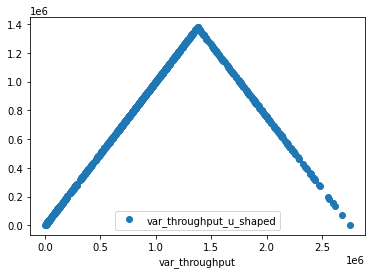

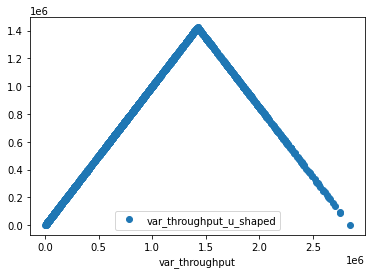

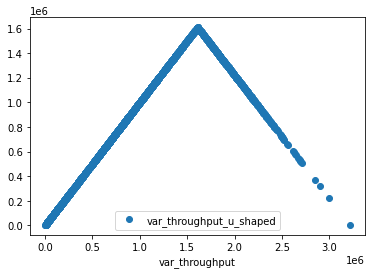

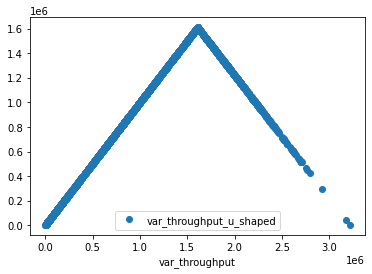

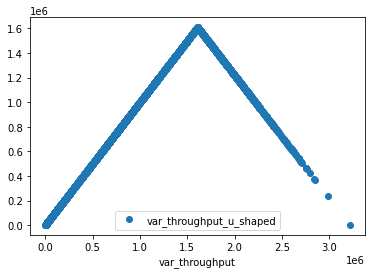

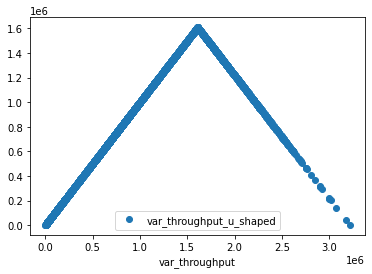

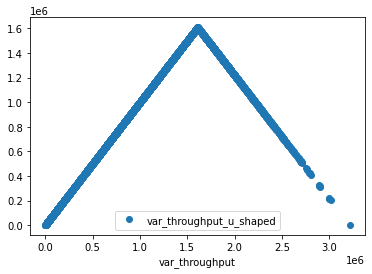

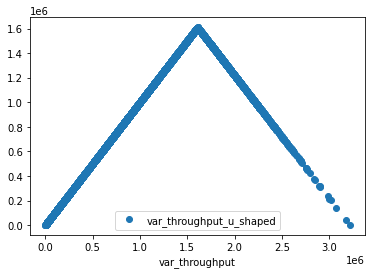

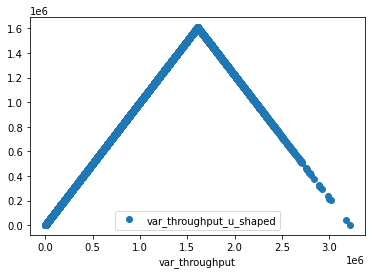

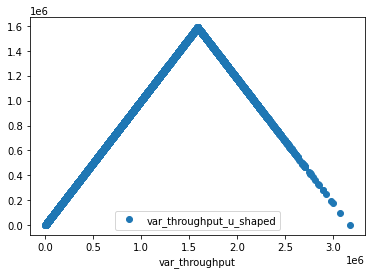

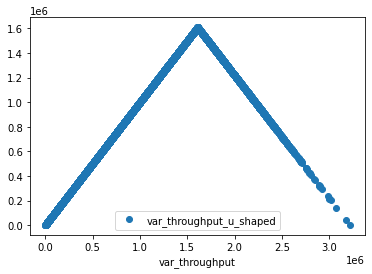

In [9]:
sampling_sizes = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11366]

results_dict = dataset_sampling(dataframe=df, 
                                class_name="Input.deception_quadrant", 
                                sampling_size_list=sampling_sizes, 
                                metadata_options_list=metadata_options_choices, 
                                model_name=model_name)

In [10]:
def translate_into_pandas(results_dictionary, metric_of_focus):
    def helper(metric_of_focus_number):
        new_dict = {}
        for each_key, each_values_list in results_dictionary.items():
            new_dict[each_key[4:]] = []
            for each in each_values_list:
                new_dict[each_key[4:]].append(each[metric_of_focus_number])
        out_df = pd.DataFrame.from_dict(new_dict)
        return out_df
    
    if metric_of_focus == 'F1':
        metric_of_focus_number = 0
    elif metric_of_focus == 'Precision':
        metric_of_focus_number = 1
    elif metric_of_focus == 'Recall':
        metric_of_focus_number = 2
        
    return helper(metric_of_focus_number)

experiment_df = translate_into_pandas(results_dict, 'Precision')
experiment_df

,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11366
0,0.000000,0.982143,0.970833,0.966149,0.976402,0.970331,0.967938,0.962500,0.959590,0.954102,0.950623
1,0.988281,0.982143,0.970833,0.965144,0.978516,0.968476,0.967938,0.962500,0.959590,0.954102,0.950623
2,0.988281,0.982832,0.970833,0.965099,0.978516,0.987697,0.967938,0.965211,0.961730,0.954102,0.945379
3,0.988281,0.982143,0.970833,0.965144,0.978516,0.968476,0.967938,0.962500,0.959590,0.954102,0.950623
4,0.988281,0.980851,0.977926,0.967854,0.978516,0.968476,0.000000,0.962500,0.959590,0.951963,0.000000
5,0.988281,0.982143,0.970833,0.965144,0.978516,0.968476,0.967938,0.962500,0.959590,0.954102,0.950623
6,0.988281,0.714286,0.000000,0.975722,0.976623,0.966896,0.967938,0.000000,0.958355,0.000000,0.950623
7,0.988281,0.982143,0.970833,0.965144,0.978516,0.968476,0.967938,0.962500,0.959590,0.954102,0.950623
8,0.000000,0.968287,0.955188,0.965144,0.975096,0.968476,0.967938,0.962500,0.959590,0.954102,0.950499
9,0.988281,0.982143,0.970833,0.965144,0.978516,0.968476,0.967938,0.962500,0.959590,0.954102,0.950623


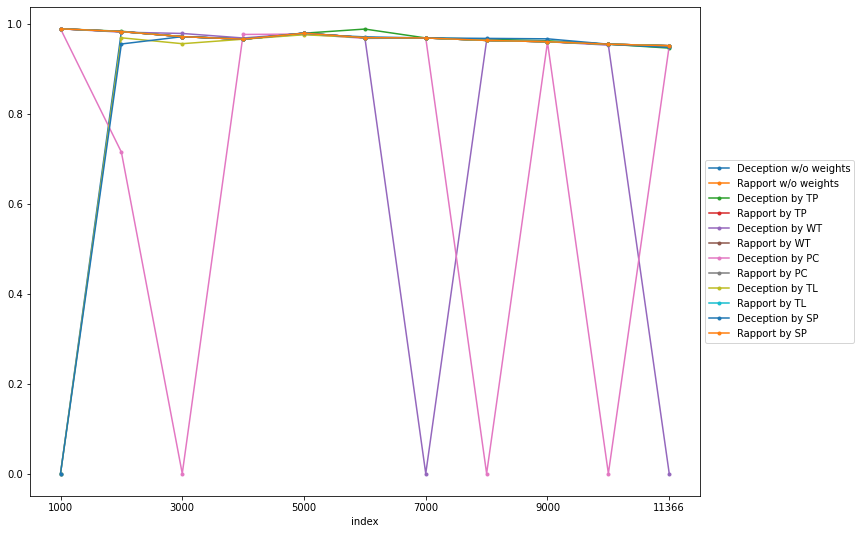

In [23]:
exp_plot_df = experiment_df.T.reset_index()
rename_col_names = {0: 'Deception w/o weights',
                    1: 'Rapport w/o weights',
                    2: 'Deception by TP',
                    3: 'Rapport by TP',
                    4: 'Deception by WT',
                    5: 'Rapport by WT',
                    6: 'Deception by PC',
                    7: 'Rapport by PC',
                    8: 'Deception by TL',
                    9: 'Rapport by TL',
                    10: 'Deception by SP',
                    11: 'Rapport by SP'}
exp_plot_df = exp_plot_df.rename(columns=rename_col_names)
exp_plot_df.plot('index',list(exp_plot_df.columns)[1:],style='.-', figsize=(12,9)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))